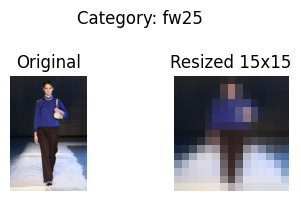

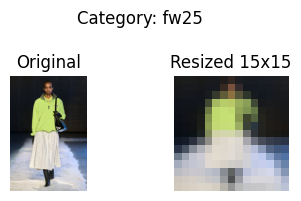

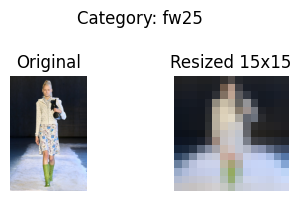

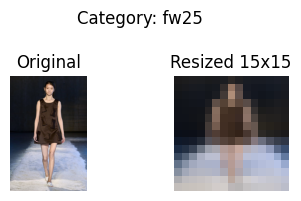

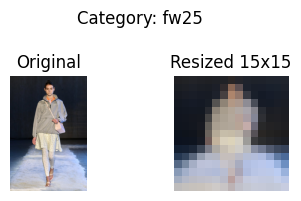

Data shape: (589, 675)
Labels shape: (589,)
88.13559322033898% of samples were correctly classified


In [4]:
import os
import numpy as np
import pandas as pd
from skimage.io import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import pickle
import matplotlib.pyplot as plt


# prepare data
folder = 'images'
input_dir = folder
categories = ['fw25','ss25','r25','fw24','ss24','r24','fw23','ss23','fw22','ss22','r22','fw21','ss21','ss20','r20','fw20','fw19','ss19','r19']

data = []
labels = []

# visualize
image_extensions = ('.jpg')
visualize_limit = 5  # number of sample images to visualize
visualized = 0

for category_idx, category in enumerate(categories):
    category_path = os.path.join(input_dir, category)
    if not os.path.exists(category_path):
        print(f"Warning: Category folder '{category_path}' not found. Skipping.")
        continue

    for file in os.listdir(category_path):
        if not file.lower().endswith(image_extensions):
            continue  # Skip non-image files

        img_path = os.path.join(category_path, file)
        try:
            img = imread(img_path)
            resized_img = resize(img, (15, 15), anti_aliasing=True)
            data.append(resized_img.flatten())
            labels.append(category_idx)

        # visualize
            if visualized < visualize_limit:
                plt.figure(figsize=(4, 2))
                plt.subplot(1, 2, 1)
                plt.imshow(img)
                plt.title("Original")
                plt.axis('off')

                plt.subplot(1, 2, 2)
                plt.imshow(resized_img)
                plt.title("Resized 15x15")
                plt.axis('off')

                plt.suptitle(f"Category: {category}")
                plt.tight_layout()
                plt.show()
                visualized += 1
        except Exception as e:
            print(f"Error reading image {img_path}: {e}")

data = np.asarray(data)
labels = np.asarray(labels)

print("Data shape:", data.shape)
print("Labels shape:", labels.shape)

#test/train data split
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size = 0.2, shuffle = True, stratify = labels)

#train classifier
classifier = SVC()

parameters = [{'gamma':[0.01,0.001,0.0001], 'C':[1,10,100,1000]}]

grid_search = GridSearchCV(classifier, parameters)

grid_search.fit(x_train, y_train)

# evaluate
best_estimator = grid_search.best_estimator_

y_prediction = best_estimator.predict(x_test)

score = accuracy_score(y_prediction, y_test)
print('{}% of samples were correctly classified'.format(str(score*100)))

# save model
pickle.dump(best_estimator, open('./imgclass','wb'))

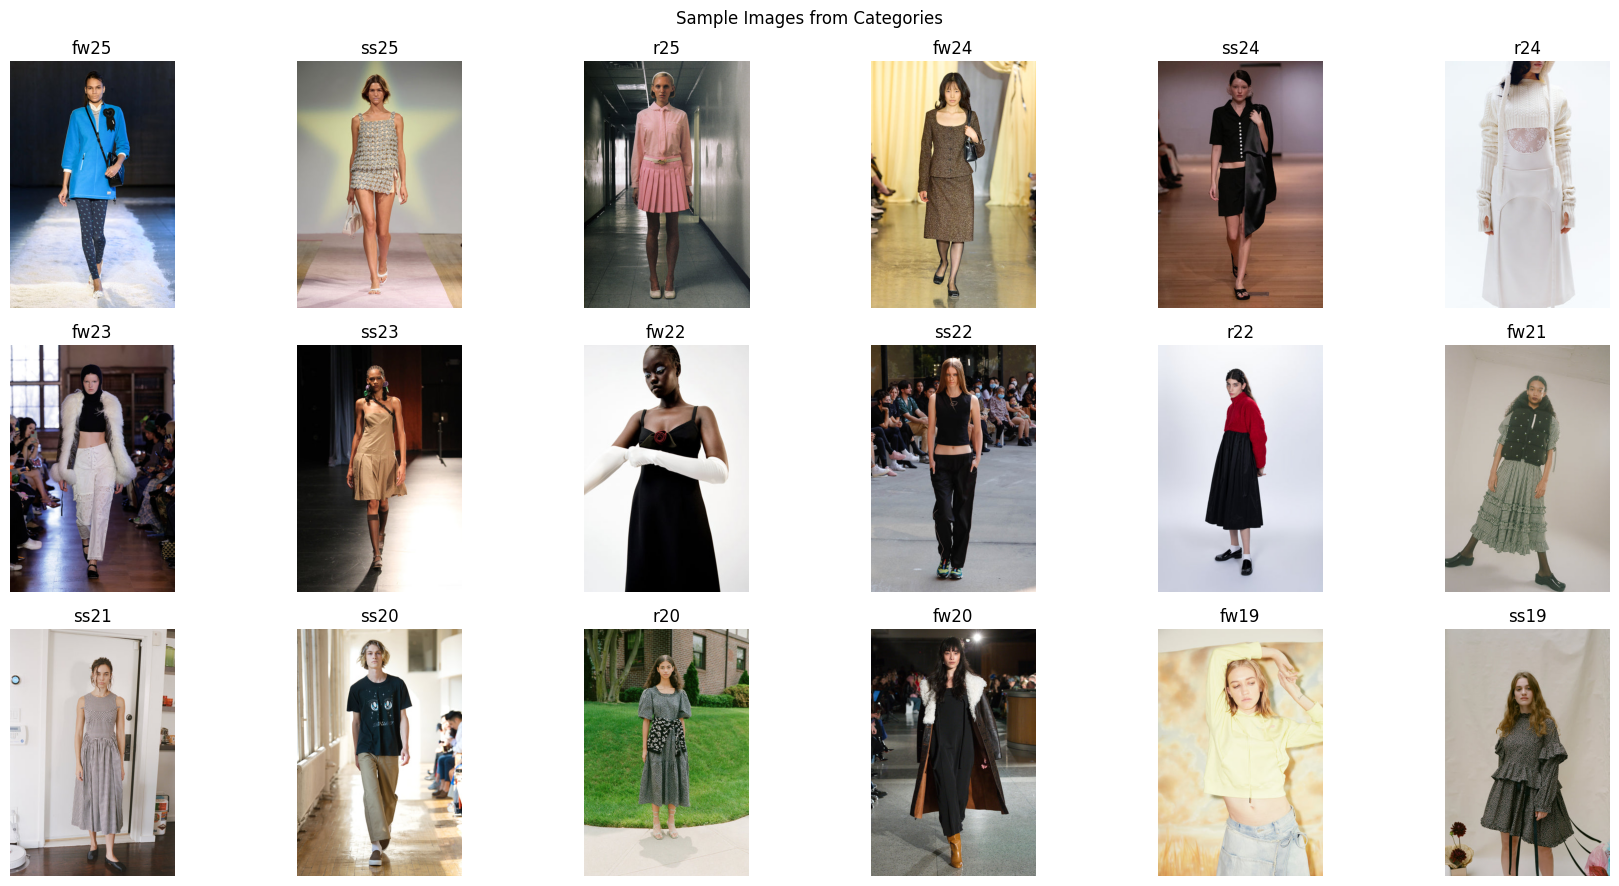

In [53]:
# sample image per category
import random

plt.figure(figsize=(18, 9))
for i, category in enumerate(categories[:18]):  # show 19 categories
    category_path = os.path.join(input_dir, category)
    images = [f for f in os.listdir(category_path) if f.endswith(image_extensions)]
    if images:
        img_path = os.path.join(category_path, random.choice(images))
        img = imread(img_path)
        plt.subplot(3, 6, i + 1)
        plt.imshow(img)
        plt.title(category)
        plt.axis('off')
plt.suptitle('Sample Images from Categories')
plt.tight_layout()
plt.show()


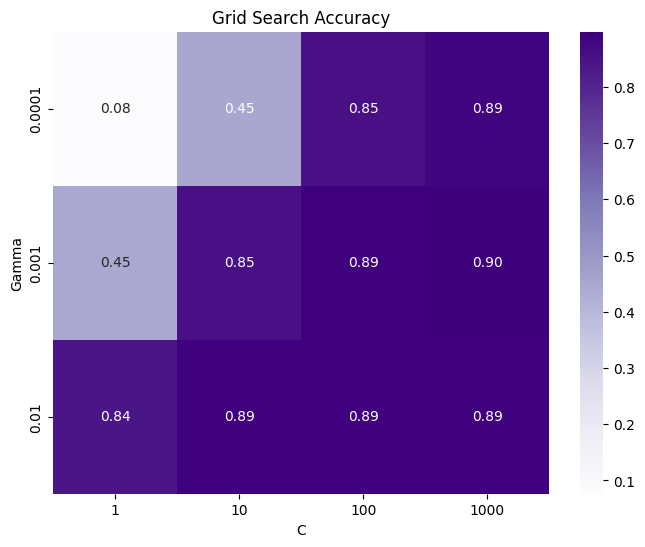

In [76]:
# parameter  plot
results = pd.DataFrame(grid_search.cv_results_)
pivot = results.pivot(index='param_gamma', columns='param_C', values='mean_test_score')

import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap='Purples')
plt.title('Grid Search Accuracy')
plt.xlabel('C')
plt.ylabel('Gamma')
plt.show()



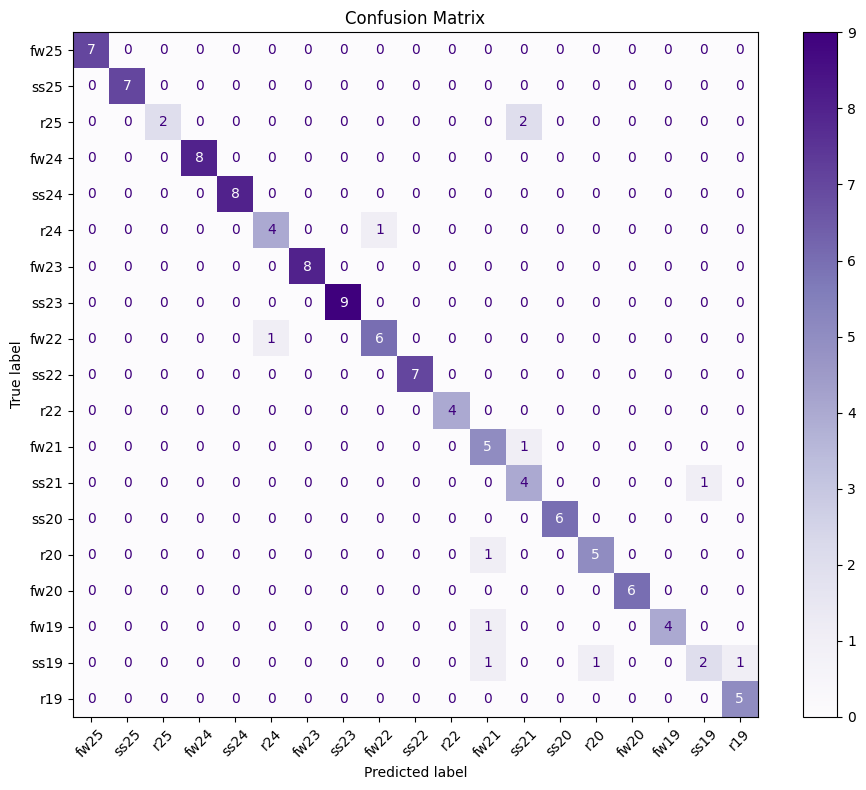

In [71]:
# confusion matrix 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_prediction = best_estimator.predict(x_test)

# plot
cm = confusion_matrix(y_test, y_prediction, labels=np.unique(y_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[categories[i] for i in np.unique(y_test)])

fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, xticks_rotation=45, cmap='Purples')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


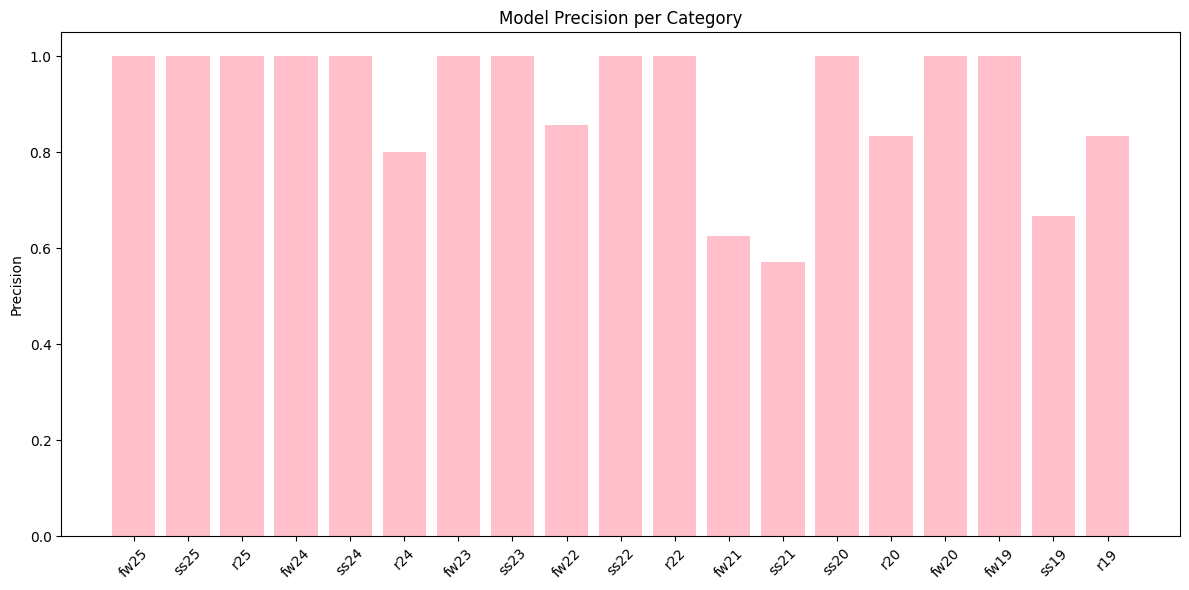

In [78]:
# model precision plot
from sklearn.metrics import classification_report

report = classification_report(y_test, y_prediction, output_dict=True)
accuracies = [report[str(i)]['precision'] for i in np.unique(y_test)]

plt.figure(figsize=(12, 6))
plt.bar([categories[i] for i in np.unique(y_test)], accuracies, color='pink')
plt.xticks(rotation=45)
plt.ylabel("Precision")
plt.title("Model Precision per Category")
plt.tight_layout()
plt.show()


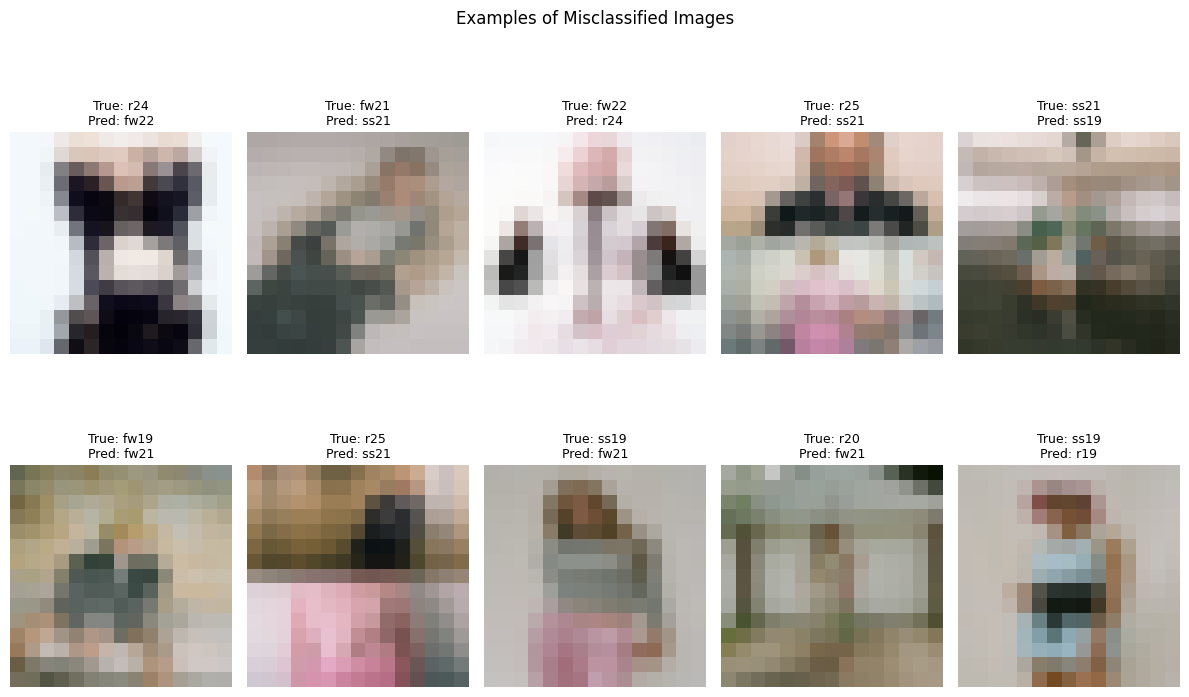

In [72]:
# examples of misclassified images
misclassified_indices = np.where(y_prediction != y_test)[0]

plt.figure(figsize=(12, 8))
for i, idx in enumerate(misclassified_indices[:10]):  # Show up to 10
    img = x_test[idx].reshape(15, 15, -1)
    true_label = categories[y_test[idx]]
    pred_label = categories[y_prediction[idx]]
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.title(f'True: {true_label}\nPred: {pred_label}', fontsize=9)
    plt.axis('off')

plt.suptitle('Examples of Misclassified Images')
plt.tight_layout()
plt.show()


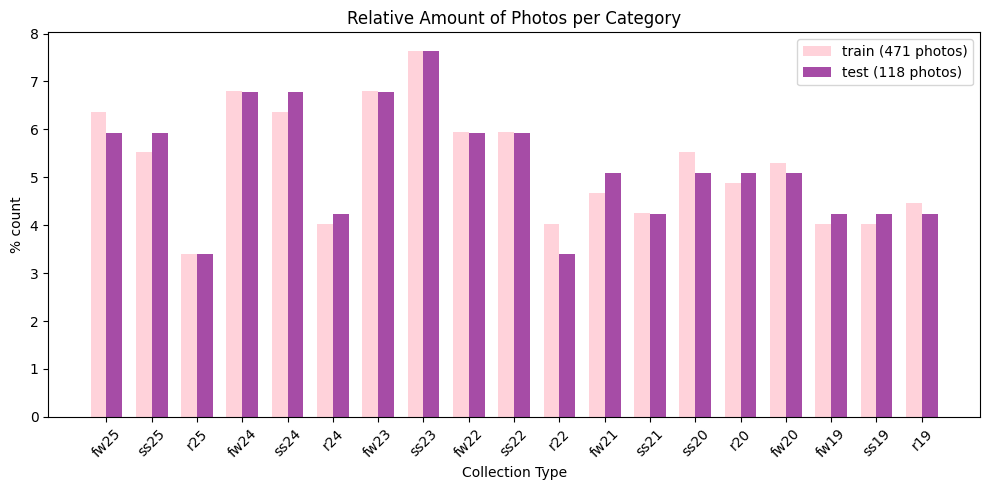

In [81]:
# train/test plot
def plot_bar(y, loc='left', relative=True, color=None):
    width = 0.35
    n = -0.5 if loc == 'left' else 0.5

    unique, counts = np.unique(y, return_counts=True)
    sorted_index = np.argsort(unique)
    unique = unique[sorted_index]

    if relative:
        counts = 100 * counts[sorted_index] / len(y)
        ylabel_text = '% count'
    else:
        counts = counts[sorted_index]
        ylabel_text = 'count'

    xtemp = np.arange(len(unique))
    plt.bar(
        xtemp + n * width,
        counts,
        align='center',
        alpha=0.7,
        width=width,
        color=color  # <- now supports color
    )
    plt.xticks(xtemp, [categories[u] for u in unique], rotation=45)
    plt.xlabel('Collection Type')
    plt.ylabel(ylabel_text)

#plot
plt.figure(figsize=(10, 5))
plot_bar(y_train, loc='left', color='pink')
plot_bar(y_test, loc='right', color='purple')
plt.legend([
    f'train ({len(y_train)} photos)', 
    f'test ({len(y_test)} photos)'
])
plt.title('Relative Amount of Photos per Category')
plt.tight_layout()
plt.show()


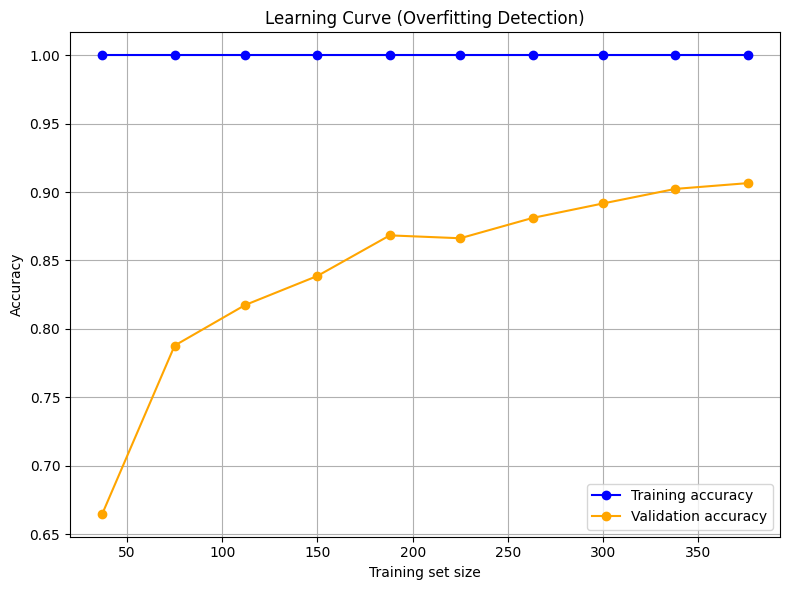

In [86]:
# learning curve plot
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    estimator=best_estimator,  # from GridSearchCV
    X=x_train,
    y=y_train,
    cv=5,                      # 5-fold cross-validation
    train_sizes=np.linspace(0.1, 1.0, 10),  # from 10% to 100% of training data
    scoring='accuracy',
    n_jobs=-1
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Training accuracy')
plt.plot(train_sizes, test_scores_mean, 'o-', color='orange', label='Validation accuracy')

plt.title('Learning Curve (Overfitting Detection)')
plt.xlabel('Training set size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()
